# Ex4

In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# local imports
import MNIST_dataloader
from scipy import linalg
import os
import bokeh
import Fast_MRI_dataloader 
from ISTA import ISTAI_main
PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print('Folders in the Fast_MRI_Knee:',os.listdir(PATH)) # os.listdir(PATH)
# Batch size
batch_size = 64
# Load train and test
# train_loader, test_loader = MNIST_dataloader.create_dataloaders(PATH, batch_size)
import warnings
warnings.filterwarnings("ignore") # Turn off warnings

PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print(PATH)

train_loader, test_loader = Fast_MRI_dataloader.create_dataloaders(PATH, batch_size)

def calculate_full_kspace(input):
    return(torch.fft.fftshift(torch.fft.fft2(input)))

def get_partial_kspace(fks,M): # get masked k-space
    return(torch.mul(fks,M)) # multiply

def get_accelerated_measurement_image(pks):
    return(torch.fft.ifft2(torch.fft.ifftshift(pks)))

d:\01_School\Q4_5LSL0_MachineLearningForsignalProcessing\SignalProcessing\5LSL0_HW\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Folders in the Fast_MRI_Knee: ['MNIST', 'test', 'train']
d:\01_School\Q4_5LSL0_MachineLearningForsignalProcessing\SignalProcessing\5LSL0_HW\Assignment4\Code - for students\Fast_MRI_Knee


In [2]:
for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
    fkspace = calculate_full_kspace(gt)            # ground full k-space
    pks = get_partial_kspace(fkspace,M)            # get partial k-space
    amimg = get_accelerated_measurement_image(pks) # get M ⊙ (FX + N)
    continue

100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


In [3]:
def Feq_Kspace_plt(inputs):
    return torch.log(torch.abs(inputs)+1e-20)



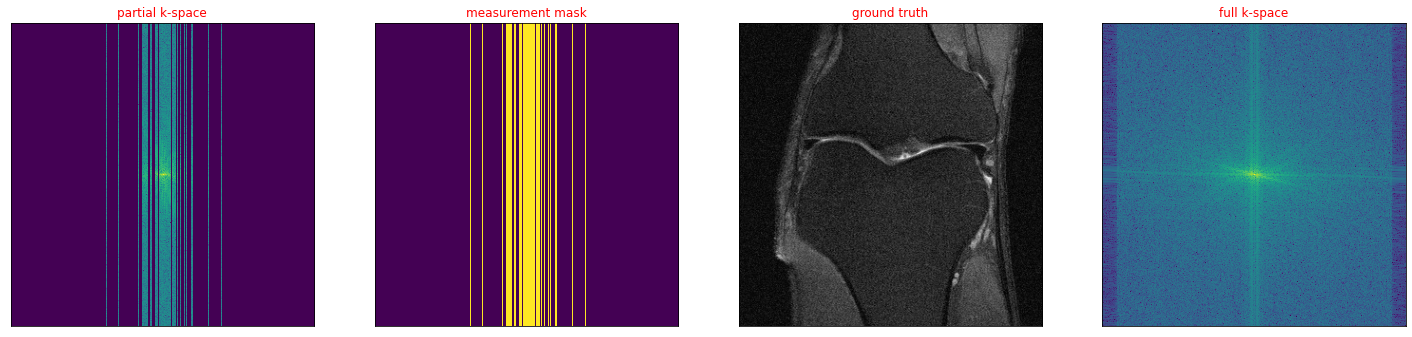

In [4]:
pkspace_plot_friendly = torch.log(torch.abs(pks[0,:,:])+1e-20)
fkspace_plot_friendly = torch.log(torch.abs(fkspace[0,:,:])+1e-20) # this k-space is frquency domain with complex, and + 1e-20 fo compensate.
# %% plot the last example
kspace_plot_friendly = torch.log(torch.abs(kspace[0,:,:])+1e-20)

plt.figure(figsize = (25,35))
plt.subplot(1,4,1)
plt.imshow(kspace_plot_friendly,vmin=-2.3,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('partial k-space',color='red')

plt.subplot(1,4,2)
plt.imshow(M[0,:,:],interpolation='nearest') # mask
plt.xticks([])
plt.yticks([])
plt.title('measurement mask',color='red')

plt.subplot(1,4,3)
plt.imshow(gt[0,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ground truth',color='red')

plt.subplot(1,4,4)
plt.imshow(fkspace_plot_friendly,vmin=-2.3,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('full k-space',color='red')

# plt.savefig("example.png",dpi=300,bbox_inches='tight')
plt.show()
plt.close()

Text(0.5, 1.0, 'Denoise')

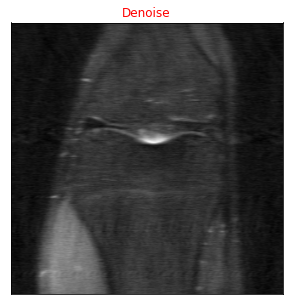

In [116]:
# denoise
# ISTA
# y - ground truth
# mu 
mu = 0.01
lmbd = 0.1
k = 10
shrinkage = mu*lmbd
#---------------------------------------------------------------------------
# full k-space


def ISTA_MRI(y,M,mu,lamd,k):
    y_img = get_accelerated_measurement_image(torch.abs(y))
    shrinkage = mu*lamd
    M_inv = torch.abs(M - 1)

    for i in range(k):
        tr_Fullk = torch.log(calculate_full_kspace(torch.abs(y_img))) # frequency domain to full k-space
        x_k = torch.abs(tr_Fullk * M_inv) + y
        x_k_new = torch.abs(get_accelerated_measurement_image(x_k))
        x_recon = torch.abs(torch.multiply(torch.sign(x_k_new) ,torch.maximum(torch.abs(x_k_new) - shrinkage, torch.tensor(0.))))

    return x_recon

a = pks[2,:,:]

restul = ISTA_MRI(a,M[0,:,:],mu,lmbd,k=10)

plt.figure(figsize = (5,5))
# plt.imshow(Feq_Kspace_plt(a),cmap='gray')
plt.imshow(restul,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title('Denoise',color='red')


Text(0.5, 1.0, 'ISTA conversion')

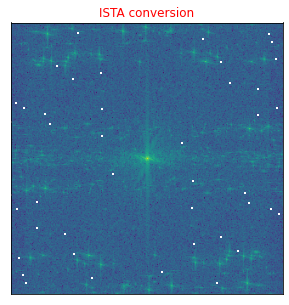

In [11]:


# plt.figure(figsize = (5,5))
# # plt.imshow(ISTA_conv)
# plt.xticks([])
# plt.yticks([])
# plt.title('ISTA conversion',color='red')

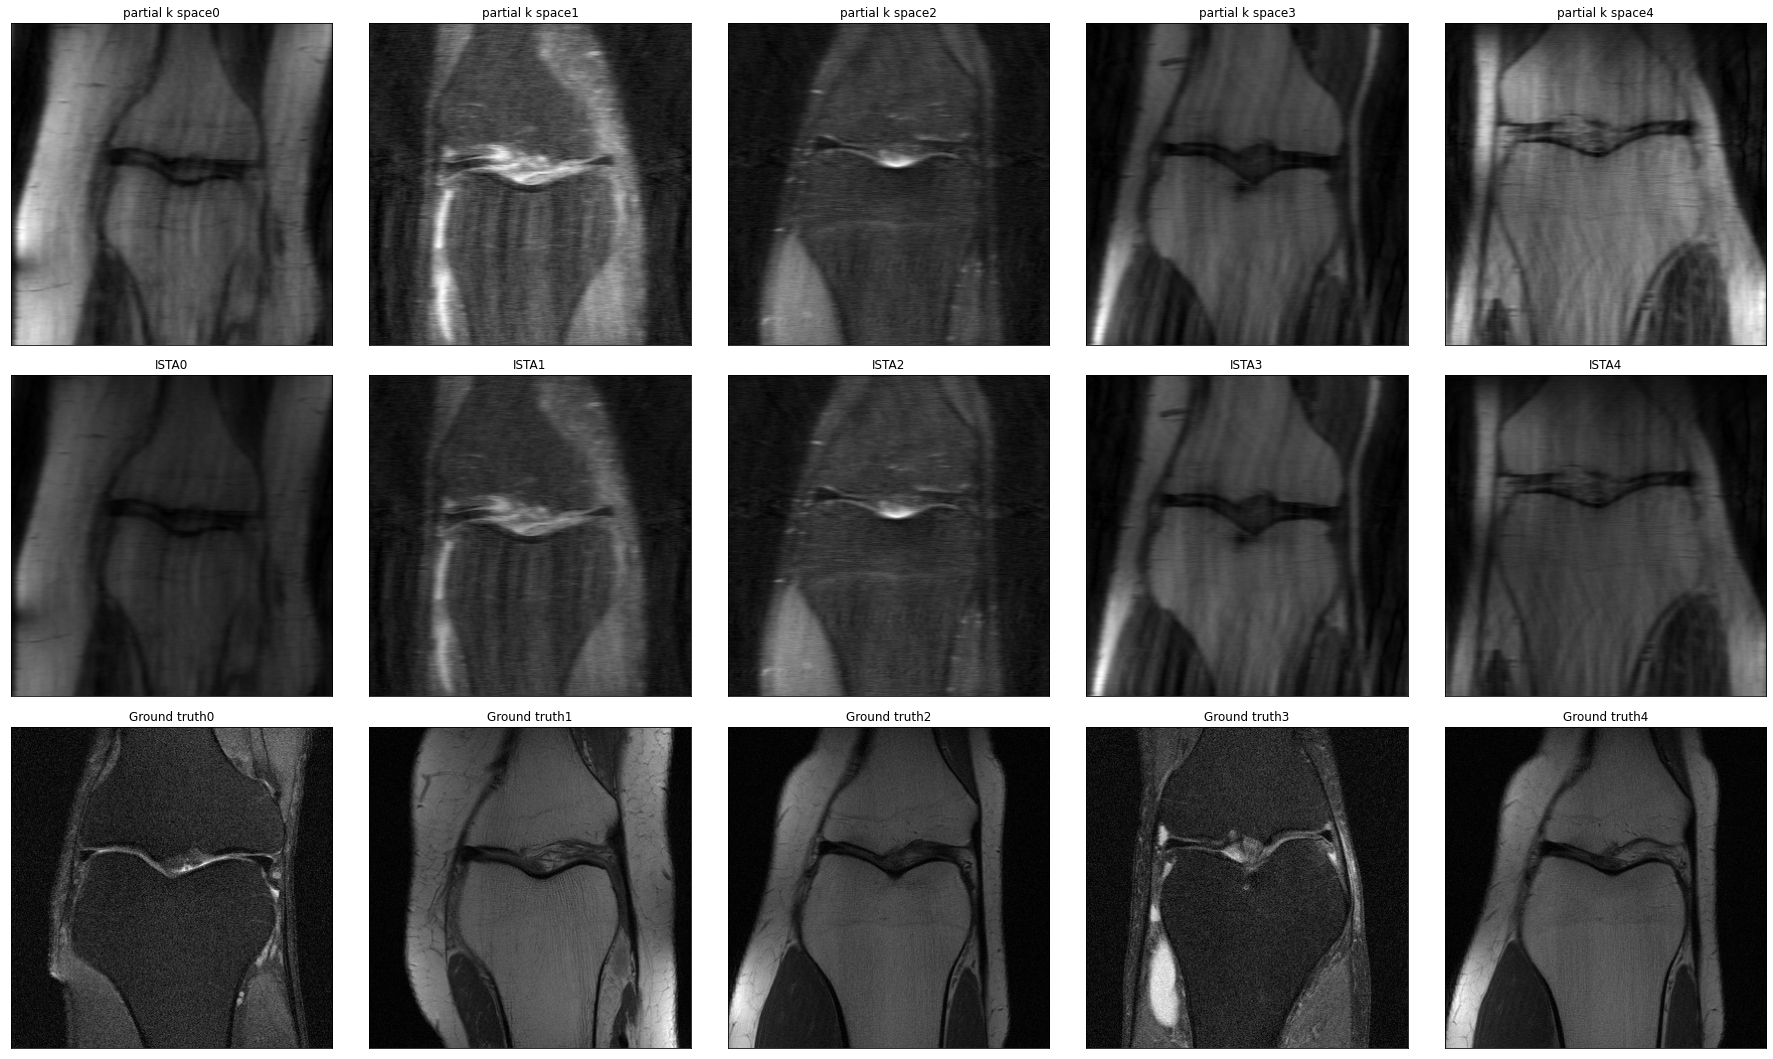

In [121]:
x_hat = dict()
n = 5

k=10

for i in range(5):
    x_hat[i] = ISTA_MRI(pks[i,:,:],M[0,:,:],mu,lmbd,k)

fig = plt.figure(figsize=(25,15))
for i in range(5):

    ax = fig.add_subplot(3, 5, i+1)
    plot_kspace = get_accelerated_measurement_image(pks[i,:,:])
    plt_kspace = torch.abs(plot_kspace)+1e-20
    ax.imshow((plt_kspace),cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plt.title('partial k space'+str(i))

    ax2 = fig.add_subplot(3, 5, i+6)
    ax2.imshow(x_hat[i],cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    plt.title('ISTA'+str(i))
    ax3 = fig.add_subplot(3, 5, i+11)
    ax3.imshow(gt[i,:,:],cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    plt.title('Ground truth'+str(i))

Image_path = os.path.join(os.getcwd(),'Image')

plt.savefig(os.path.join(Image_path,'Ex4.png'),dpi=300,bbox_inches='tight')